In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
# 1. Load and preprocess data
def load_mnist_data():
    (x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data() # Load MNIST dataset
    x_train = x_train.astype("float32") / 255.0 # Normalize pixel values to [0, 1]
    x_test = x_test.astype("float32") / 255.0 # Normalize pixel values to [0, 1]
    x_train = np.expand_dims(x_train, -1) # shape: (num_samples, 28, 28, 1)
    x_test = np.expand_dims(x_test, -1) 
    return x_train, x_test


In [3]:
# 2. Build the autoencoder
def build_autoencoder(input_shape, latent_dim):
    # Encoder
    encoder_input = layers.Input(shape=input_shape) # shape: (28, 28, 1)
    x = layers.Flatten()(encoder_input) # Flatten the input -- shape: (28, 28, 1) -> (784,)
    x = layers.Dense(128, activation='relu')(x) # Fully connected layer -- shape: (784,) -> (128,)
    x = layers.Dense(64, activation='relu')(x)  # Another fully connected layer -- shape: (128,) -> (64,)
    # Latent space representation
    latent = layers.Dense(latent_dim, activation='relu')(x) # shape: (64,) -> (latent_dim,)
    encoder = models.Model(encoder_input, latent, name='encoder') # Create the encoder model

    # Decoder
    decoder_input = layers.Input(shape=(latent_dim,)) # shape: (latent_dim,)
    x = layers.Dense(128, activation='relu')(decoder_input) # Fully connected layer -- shape: (latent_dim,) -> (128,)
    x = layers.Dense(np.prod(input_shape), activation='sigmoid')(x) # Fully connected layer -- shape: (128,) -> (784,)
    decoder_output = layers.Reshape(input_shape)(x) # Reshape to original input shape -- shape: (784,) -> (28, 28, 1)
    decoder = models.Model(decoder_input, decoder_output, name='decoder') # Create the decoder model

    # Autoencoder = encoder + decoder
    autoencoder_input = encoder_input # Input for the autoencoder is the same as the encoder
    encoded = encoder(autoencoder_input) # Get the encoded representation
    reconstructed = decoder(encoded) # Reconstruct the input from the encoded representation
    autoencoder = models.Model(autoencoder_input, reconstructed, name='autoencoder') # Create the autoencoder model
    return autoencoder, encoder, decoder

In [4]:
# 3. Train the autoencoder
def train_autoencoder(autoencoder, x_train, x_test, epochs=20, batch_size=256):
    autoencoder.compile(optimizer='adam', loss='mse')
    history = autoencoder.fit(x_train, x_train,
                              validation_data=(x_test, x_test),
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=2)
    return history

In [5]:
# 4. Visualize reconstruction
def plot_reconstruction(autoencoder, x_test, num_images=10):
    decoded_imgs = autoencoder.predict(x_test[:num_images])
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Original
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        # Reconstructed
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle("Top: Original | Bottom: Reconstructed", fontsize=16)
    plt.show()

In [6]:
# 5. Use case: Anomaly detection (reconstruction error)
def detect_anomalies(autoencoder, normal_data, suspect_data, threshold=None):
    reconstructions = autoencoder.predict(suspect_data)
    mse = np.mean(np.square(suspect_data - reconstructions), axis=(1, 2, 3))
    if threshold is None:
        threshold = np.mean(mse) + 3 * np.std(mse)  # Dynamic threshold
    anomalies = mse > threshold
    return anomalies, mse, threshold

Epoch 1/20
235/235 - 3s - 13ms/step - loss: 0.0628 - val_loss: 0.0361
Epoch 2/20
235/235 - 1s - 5ms/step - loss: 0.0291 - val_loss: 0.0237
Epoch 3/20
235/235 - 1s - 5ms/step - loss: 0.0219 - val_loss: 0.0195
Epoch 4/20
235/235 - 1s - 5ms/step - loss: 0.0187 - val_loss: 0.0173
Epoch 5/20
235/235 - 1s - 5ms/step - loss: 0.0167 - val_loss: 0.0155
Epoch 6/20
235/235 - 1s - 5ms/step - loss: 0.0153 - val_loss: 0.0143
Epoch 7/20
235/235 - 1s - 5ms/step - loss: 0.0142 - val_loss: 0.0134
Epoch 8/20
235/235 - 1s - 5ms/step - loss: 0.0135 - val_loss: 0.0128
Epoch 9/20
235/235 - 1s - 5ms/step - loss: 0.0129 - val_loss: 0.0124
Epoch 10/20
235/235 - 1s - 5ms/step - loss: 0.0124 - val_loss: 0.0120
Epoch 11/20
235/235 - 1s - 5ms/step - loss: 0.0120 - val_loss: 0.0115
Epoch 12/20
235/235 - 1s - 5ms/step - loss: 0.0116 - val_loss: 0.0111
Epoch 13/20
235/235 - 1s - 5ms/step - loss: 0.0113 - val_loss: 0.0108
Epoch 14/20
235/235 - 1s - 5ms/step - loss: 0.0110 - val_loss: 0.0105
Epoch 15/20
235/235 - 1s - 5

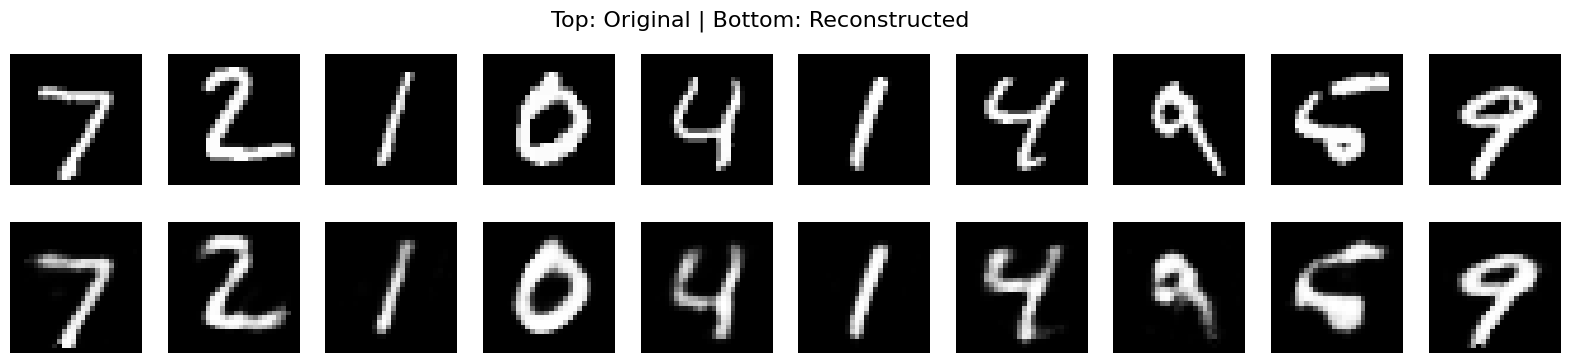

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Detected anomalies: 110
MSE scores: [0.00361605 0.01593858 0.00209358 0.00713232 0.00857991 0.00090034
 0.01444255 0.01577349 0.01354055 0.00850323]
Threshold for anomaly detection: 0.025375098


In [7]:
# Run everything
x_train, x_test = load_mnist_data()
autoencoder, encoder, decoder = build_autoencoder(input_shape=(28, 28, 1), latent_dim=32) # Latent dimension can be adjusted -- Latent dim is the size of the compressed representation
train_autoencoder(autoencoder, x_train, x_test, epochs=20) 
plot_reconstruction(autoencoder, x_test)

# Anomaly detection (using normal test images)
anomalies, mse_scores, threshold = detect_anomalies(autoencoder, x_train, x_test)
print("Detected anomalies:", np.sum(anomalies))
print("MSE scores:", mse_scores[:10])  # Print first 10 MSE scores
print("Threshold for anomaly detection:", threshold)